In [1]:
import requests #This Python library allows me to access and communicate with web APIs by sending HTTP requests.
import time #This code uses the time-related capabilities provided by this module to limit the rate at which requests are made.

class APIwrapper: #This line defines a class named APIwrapper. It handles pagination, ensures appropriate rate-limiting, and covers the code for communicating with an API endpoint.
    _access_point="https://api.ukhsa-dashboard.data.gov.uk" #It saves the base URL of the API endpoint that requests will be sent using by the APIwrapper class.
    _last_access=0.0 #Record the last time of API accessed using for rate limiting.
    
    def __init__(self, theme, sub_theme, topic, geography_type, geography, metric):
        """ Init the APIwrapper object, constructing the endpoint from the structure
        parameters """
        # This is the APIwrapper class's constructor (__init__). The newly generated object is initialised using a specific method called the constructor.
        # It takes in a number of parameters (theme, sub_theme, topic, geography_type, geography, metric), which are used to construct the API request URL and set up the object. According to the docstring, the constructor's task is to use the supplied parameters to build the API endpoint.
        url_path=(f"/themes/{theme}/sub_themes/{sub_theme}/topics/{topic}/geography_types/" +
                  f"{geography_type}/geographies/{geography}/metrics/{metric}")
        # The URL path for the API request is dynamically formatted in this line using an f-string.
        # The values supplied to the constructor are substituted by the f-string for theme, sub_theme, topic, geography_type, geography, and metric. This generates a URL route that reflects the particular API request structure.
        self._start_url=APIwrapper._access_point+url_path #The full API endpoint URL is created in this line by combining the url_path produced in the previous line with the static class variable _access_point, which is the base URL for the API.
        # The instance variable self._start_url contains the final full URL.
        self._filters=None #The instance variable _filters is initialised to None by this line. Any filter conditions that can be used while retrieving data from the API are meant to be stored in the _filters variable.
        # It stays at None if no filters are set. Later on, filters can be applied to change the data that the API returns.
        self._page_size=-1 #The instance variable _page_size is initialised to -1 by this line. The number of data points returned per page in each API request is managed by the _page_size variable.
        # The page size is not defined if it is not set, as indicated by the default value of -1. Later, when the API is called, the real page size will be supplied.
        self.count=None #The instance variable count is set to None by this line. The entire number of items accessible for the query is stored in the count variable. This value will be updated with the total number of results available after the data has been retrieved from the API.

    def get_page(self, filters={}, page_size=5):
        """ Access the API and download the next page of data. Sets the count
        attribute to the total number of items available for this query. Changing
        filters or page_size will cause get_page to restart from page 1. Rate
        limited to three request per second. The page_size parameter sets the number
        of data points in one response page (maximum 365); use the default value 
        for debugging your structure and filters. """
        # This is how the APIwrapper class's get_page method is defined. This method's objective is to obtain the subsequent page of data from the API.
        # Define filter conditions for the data by using the optional filters argument.
        # The number of data points (items) that should be returned per page is specified by page_size. It has five things per page by default.
        #Along with various limitations (such rate limits and the maximum supported page size of 365), the function also comes with a docstring that explains what it does.
        if page_size>365:
            raise ValueError("Max supported page size is 365")
        # This line determines if the page_size is greater than the 365 maximum allowed value. The function raises a ValueError with the relevant error message if it does.
        # This is a precaution to make sure that the page_size option doesn't go over the limit of 365 items per page, which is the most that the API supports.
        if filters!=self._filters or page_size!=self._page_size:
            self._filters=filters
            self._page_size=page_size
            self._next_url=self._start_url
        # This block determines whether the page_size or the filters have changed since the last request.
        # It sets _next_url back to the initial URL (_start_url) and modifies the appropriate instance variables (_filters and _page_size) if they have changed.
        # This ensures that you obtain the data in accordance with the updated filters and page size by essentially restarting the data fetching process from the first page.
        if self._next_url==None: 
            return [] # In order to determine whether there are any more pages of data to retrieve, this checks to see if _next_url is None.
        # The function indicates that the final page has already been fetched if this is the case by returning an empty list [].
        curr_time=time.time() # Time is equal to curr_time.Using Unix timestamp format, time() retrieves the current time in seconds since January 1, 1970.
        deltat=curr_time-APIwrapper._last_access
        #The time difference (deltat) between the current time and the last time the API was used is determined by using the formula deltat = curr_time - APIwrapper._last_access.
        # In order to prevent requests from exceeding the API's rate limit, this is used for rate restriction.
        if deltat<0.33: # This line determines whether there is a time gap of less than 0.33 seconds (i.e., three requests per second) between the current and previous requests. It waits (time.sleep) for the remaining time before submitting the subsequent request if it is too early.
            time.sleep(0.33-deltat) # This prevents the software from sending requests more quickly than the API permits (3 requests per second) by enforcing the rate limit.
        APIwrapper._last_access=curr_time
        # This adds the current time (curr_time) to the class variable _last_access. It guarantees that for the subsequent API call, the rate-limiting mechanism operates as intended.
        parameters={x: y for x, y in filters.items() if y!=None}
        parameters['page_size']=page_size
        # Only the filter key-value pairs where the value is not None are included in the dictionary parameters created in the first line. Only the elements where the value is not None are retained after iterating through the filters dictionary using a dictionary comprehension.
        # The page_size, which indicates how many items should be returned per page, is added to the parameters dictionary in the second line.
        response = requests.get(self._next_url, params=parameters).json()
        # This uses the requests to submit an HTTP GET request to the API.obtain a way.
        # The URL from which the data is being retrieved is self._next_url, and the filters and page size are sent as URL query parameters via params=parameters.
        # The API answer is decoded into a Python dictionary using the.json() method. The data for the current page is contained in the response.
        self._next_url=response['next']# response['next'] = self._next_url The URL for the following page of data, which is supplied by the API in the response's next field, is updated in the _next_url.
        self.count=response['count']# self.count = answer['count'] The count field of the response contains the total number of items available for this query, which is updated in the count attribute.
        
        return response['results'] # This gives back the information from the current results page, which is kept in the response's results field. # The actual data points that the API received for this page are in the results field.

    def get_all_pages(self, filters={}, page_size=365):
        """ Access the API and download all available data pages of data. Sets the count
        attribute to the total number of items available for this query. API access rate
        limited to three request per second. The page_size parameter sets the number
        of data points in one response page (maximum 365), and controls the trade-off
        between time to load a page and number of pages; the default should work well 
        in most cases. The number of items returned should in any case be equal to 
        the count attribute. """
        #The purpose of the get_all_pages method is to retrieve every data page that is accessible from the API.
        #Two optional arguments are accepted by it:filters: a list of filter options to use when submitting an API query. page_size: the maximum number of data points that the API allows per page, which is 365 by default.
        #The function's functionality is summarised in the docstring. It states that page_size controls the number of data points per page and that API rate limitation is in place (3 requests per second).

        data=[] # To gather all of the data as it is fetched from the API, an empty list data is initialised. Every page of the results that are retrieved will be added to this list.
        while True:
            # A while True loop is initiated, and it will continue to run forever until all of the data pages have been retrieved.
            # To retrieve the following page of data from the API, the function self.get_page(filters, page_size) is invoked inside the loop.
            next_page=self.get_page(filters, page_size)
            # The data for the current page, which was returned by the get_page method, will be contained in next_page.
            if next_page==[]:
                break # This condition determines if the list next_page is empty [].
                # The loop ends if it is empty, which indicates that there are no more pages to retrieve (i.e., the API has delivered all available data).
                # This indicates that every page has been retrieved and serves as the loop's terminating condition.
            data.extend(next_page) # The extend() method is used to add any data from the next_page to the data list. # All of the components from next_page are appended to data by extend(). As the loop retrieves new pages, this guarantees that all of the obtained data is added to the data list.
        return data # The function returns the data list, which now includes all of the data from every page, when the loop ends (all pages have been fetched). # The function's output is a list of every piece of information that was obtained from the API.

In [2]:
structure={"theme": "infectious_disease", 
           "sub_theme": "respiratory",
           "topic": "RSV",
           "geography_type": "Nation", 
           "geography": "England"}
# A dictionary named structure is initialised by this line. In Python, a dictionary is a set of key-value pairs, each of which corresponds to a distinct value. Here, the dictionary is utilised to contain different parameters associated with the data query you wish to construct.
# "Theme" is the key. "infectious_disease" is the value.
# This establishes the general category of the information that interests you. The data relates to diseases brought on by infections, as indicated by the "theme" key being set to "infectious_disease".
# The subject is one of the main data categories in the API you are using, and "infectious_disease" may have several subtopics, such as gastrointestinal or respiratory disorders.
# "sub_theme" is the key. "Respiratory" is the value.
# This establishes the theme's subcategory of data. The data will be especially focused on disorders that affect the respiratory system (e.g., lungs, breathing) because the "sub_theme" is "respiratory."
# By doing this, the broad "infectious_disease" category is reduced to a particular subset that is associated with respiratory disorders.
# "topic" is the key. "RSV" is the value.
# Within the "respiratory" sub-theme, the topic identifies a more focused issue. "RSV" stands for Respiratory Syncytial Virus in this instance.
# This parameter limits the query's focus to RSV-related data because this virus can cause infections of the lungs and respiratory tract, particularly in young children and elderly people.
# Key: "geography_type" Value: "Nation"
# This key specifies the level of geography for which the data will be collected. "Nation" here indicates that the data is for a country or nation as a whole.
# The geography_type helps the API determine whether the data is to be pulled for a national level (e.g., a whole country), regional level (e.g., specific regions), or some other geographic level (e.g., cities, districts).
# "geography_type" is the key. "Nation" is the value.
# The degree of geography for which the data will be gathered is indicated by this key. Here, "Nation" denotes that the information pertains to a country or nation in its whole.
# Whether the data is to be pulled for a national level (such as the entire country), regional level (such as particular regions), or another geographic level (such as cities, districts) is determined by the geography_type parameter in the API.
# "Geography" is the key. "England" is the value.
# The precise geographic area for which you wish the data is defined by this key. Since it is set to "England" in this case, the data will only pertain to England.
# This instructs the API to limit the results to information for this particular geographic area (England, for example).
# The dictionary ends with this line.

In [3]:
# RSV_healthcare_admissionRateByWeek
structure["metric"]="RSV_healthcare_admissionRateByWeek" 
# This retrieves the metric key from the structure dictionary that was previously defined.
# To specify which metric or data type you're particularly interested in obtaining via the API, utilise the "metric" key. In general, a metric is a particular statistical measure associated with the topic or data category.
# As demonstrated in earlier instances, the structure dictionary now includes the theme, sub-theme, topic, geography type, and geography; but, it does not yet indicate the type of data to be retrieved (the metric).

In [4]:
filters = {
    "theme": "infectious_disease",  
    "sub_theme": "respiratory",  
    "topic": "RSV",  
    "geography_type": "Nation",  
    "geography": "England",  
    "geography_code": "E92000001",  
    "metric": "RSV_healthcare_admissionRateByWeek",  
    "metric_group": "healthcare",  
    "stratum": "default",  
    "sex": "all",  
    "age": "75+",  
    "year": 2020,  
    "month": 9,  
    "epiweek": 40,  
    "date": "2020-09-28",  
    "metric_value": 0.0,  
    "in_reporting_delay_period": False  
}
#The query parameters for retrieving data from an API are defined using the filters dictionary.
# The disease kind (RSV), geographic area (England), age group (75+), time period (September 2020, week 40), and metric (RSV healthcare admission rate) are among the specific factors used to refine the results.
# You can request a very narrow subset of data by specifying these filters; in this case, the RSV-related healthcare admission rates for individuals 75 years of age and older in England.

In [5]:
structure["metric"]="RSV_healthcare_admissionRateByWeek"
api=APIwrapper(**structure)
admissions=api.get_all_pages()
print(f"Data points expected: {api.count}")
print(f"Data points retrieved: {len(admissions)}")
# The purpose of this code is to retrieve weekly RSV (Respiratory Syncytial Virus) healthcare admission rate statistics from a designated API.
# The query parameters, which comprise theme, sub-theme, topic, and geographic information, are first defined in the "structure" dictionary.
# These query parameters are then used to generate a "APIwrapper" object, which is then sent to the API endpoint. All of the data that matches the query is then retrieved using the "get_all_pages()" method and saved in the "admissions" variable.
# In order to confirm whether the data was delivered as anticipated, the code lastly prints the predicted number of data points (depending on the overall count of the API) and the actual number of data points retrieved. In essence, this function retrieves information from the API and verifies that the results are comprehensive.

Data points expected: 2217
Data points retrieved: 2217


In [6]:
structure["metric"]="RSV_testing_positivityByWeek"
api=APIwrapper(**structure)
positivity=api.get_all_pages()
print(f"Data points expected: {api.count}")
print(f"Data points retrieved: {len(positivity)}")
# This code retrieves information from an API regarding the RSV testing positivity rate by week. 
# First, the desired measure ("RSV_testing_positivityByWeek") is specified by updating the "structure" dictionary.
# The revised "structure", which includes all the parameters required for the API call, is then used to build an instance of the "APIwrapper" class.
# All accessible data for this measure is retrieved using the "get_all_pages()" method, and the outcomes are saved in the "positivity" variable.
# In order to confirm that all of the intended data was properly collected, the code lastly publishes two pieces of information: the actual number of data points retrieved ("len(positivity)") and the expected number of data points, as supplied by the API response ("api.count").

Data points expected: 2853
Data points retrieved: 2853


In [7]:
import json
# The "json" module, which offers methods for interacting with JSON (JavaScript Object Notation) data, can be used in Python by using the "import json" line.
# JSON is a widely used format for data interchange, particularly in relation to web services or APIs. 
# To read data from a JSON string or file or write Python data to a JSON file or string, just import this module and convert between Python objects (such as dictionaries or lists) and JSON data.
# When you need to save Python objects in a format that is simple to share with other systems or interpret JSON replies from online APIs, this is helpful.

In [8]:
with open("admissions.json", "wt") as OUTF:
    json.dump(admissions, OUTF)
# The "admissions" data is saved to a JSON file using this code snippet.
# With the "with open("admissions.json", "wt)" section, a file named "admissions.json" is opened (or created) in write mode.
# The "json.dump(admissions, OUTF)" function then puts the "admissions" data (probably a Python dictionary or list) in JSON format into that file.
#The file will be automatically closed after writing if "with" is used. This is useful for organising data so that it may be shared with other apps or read at a later time.

In [9]:
with open("positivity.json", "wt") as OUTF:
    json.dump(positivity, OUTF)
# The "positivity" data is saved to a JSON file using this code snippet.
# A file called "positivity.json" is opened (or created) in write mode ("wt" denotes text mode) using the "with open("positivity.json", "wt)" section.
# The "positivity" data, which is probably a Python dictionary or list, is then written into this file as a JSON-formatted string via the "json.dump(positivity, OUTF)" function.
# Even in the event of a process mistake, using "with" guarantees that the file is correctly closed after writing. This enables you to share the data with others in a consistent way or store it for later use.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
# The necessary Python libraries for data analysis and visualisation are imported by this code.
# Tables and data frames are examples of structured data that may be handled and altered with "pandas".
# While matplotlib.dates helps with formatting and working with date-related data, matplotlib.pyplot aids in creating a variety of visualisations, including line charts and bar plots.
# Lastly, JSON data, a standard format for information exchange between systems, can be read and written using the `json` module. These libraries work together to facilitate effective data handling, analysis, and visualisation.

In [11]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
# In Jupyter notebooks, Matplotlib plots can be shown within the notebook instead than in a separate window by using the "%matplotlib inline" magic command. In the notebook context, this facilitates seeing and interacting with visualisations.
# The resolution (dots per inch, or DPI) of the figures produced by Matplotlib is set by the plt.rcParams["figure.dpi"] = 100 line.
# By default, Matplotlib may generate lower-resolution graphics, which may appear pixelated or indistinct, particularly when dealing with bigger numbers.
# The plots become more aesthetically pleasing and simpler to read when the DPI is set to 100 because it guarantees that the visuals are sharper and have higher quality.

In [12]:
with open("admissions.json", "rt") as INFILE:
    admissions=json.load(INFILE)
with open("positivity.json", "rt") as INFILE:
    deaths=json.load(INFILE)
# This code uses the "json.load()" function to load the contents of two JSON files, “admissions.json” and “positivity.json”, into Python variables while they are open in read mode.
# The variables "admissions" and "deaths" are loaded with the data from "admissions.json" and "positivity.json," respectively.
    # Following the loading of the files' contents, the "with open" statement makes sure that the files are appropriately closed.
#This is usually done so that the data can be processed and analysed later on in the software.

In [13]:
data={}
for dataset in [admissions, positivity]:
    for entry in dataset:
        date=entry['date']
        metric=entry['metric']
        value=entry['metric_value']
        if date not in data:
            data[date]={}
        data[date][metric]=value
# With each date serving as a key, this code arranges the information from the two datasets (“admissions” and “positivity”) into a dictionary called "data". 
# It iterates through the entries for every dataset, extracts the “date”, “metric”, and “metric_value”, and saves the “metric_value” for every date under the matching “metric”.
#It makes a new entry for the date if it isn't already there in the dictionary. The end product is a dictionary that makes it simpler to analyse the data by date and metric by include a hierarchical structure of metrics and their values for each date.

In [14]:
def parse_date(datestring):
    """ Convert a date string into a pandas datetime object """
    return pd.to_datetime(datestring, format="%Y-%m-%d")
# The method "parse_date()" is defined in this code, and it takes a date string as input and turns it into a pandas "datetime" object. 
# The function parses the input date string using the pandas library's "pd.to_datetime()" method.
# The desired format of the date string is "Year-Month-Day" (e.g., "2020-09-28"), as specified by the "format"="%Y-%m-%d" parameter.
# Using pandas' date-time features, this method is helpful for transforming string representations of dates into a format that is simple to use and analyse.

In [15]:
dates=list(data.keys())
dates.sort()
dates
# This code extracts the dates from the data dictionary, stores them in a list, and then sorts them in chronological order.
# The sort() method makes sure that the dates are organised from the earliest to the latest once the list(data.keys()) gathers all of the date keys from the dictionary.
# Plotting data across time in the proper order is one example of additional analysis that can be done with this sorted set of dates.

['2017-07-03',
 '2017-07-10',
 '2017-07-17',
 '2017-07-24',
 '2017-07-31',
 '2017-08-07',
 '2017-08-14',
 '2017-08-21',
 '2017-08-28',
 '2017-09-04',
 '2017-09-11',
 '2017-09-18',
 '2017-09-25',
 '2017-10-02',
 '2017-10-09',
 '2017-10-16',
 '2017-10-23',
 '2017-10-30',
 '2017-11-06',
 '2017-11-13',
 '2017-11-20',
 '2017-11-27',
 '2017-12-04',
 '2017-12-11',
 '2017-12-18',
 '2017-12-25',
 '2018-01-01',
 '2018-01-08',
 '2018-01-15',
 '2018-01-22',
 '2018-01-29',
 '2018-02-05',
 '2018-02-12',
 '2018-02-19',
 '2018-02-26',
 '2018-03-05',
 '2018-03-12',
 '2018-03-19',
 '2018-03-26',
 '2018-04-02',
 '2018-04-09',
 '2018-04-16',
 '2018-04-23',
 '2018-04-30',
 '2018-05-07',
 '2018-05-14',
 '2018-05-21',
 '2018-05-28',
 '2018-06-04',
 '2018-06-11',
 '2018-06-18',
 '2018-06-25',
 '2018-07-02',
 '2018-07-09',
 '2018-07-16',
 '2018-07-23',
 '2018-07-30',
 '2018-08-06',
 '2018-08-13',
 '2018-08-20',
 '2018-08-27',
 '2018-09-03',
 '2018-09-10',
 '2018-09-17',
 '2018-09-24',
 '2018-10-01',
 '2018-10-

In [16]:
startdate=parse_date(dates[0])
enddate=parse_date(dates[-1])
print (startdate, ' to ', enddate)
# This code uses the “parse_date” function to parse the first and last dates from the sorted "dates" list, defining two variables, "startdate" and "enddate".
# The earliest date is "dates[0]", and the latest is "dates[-1]". These dates are parsed into pandas "datetime" objects and then printed out with the string "start date to end date."
# This enables the user to view the dataset's date range.

2017-07-03 00:00:00  to  2024-11-18 00:00:00


In [17]:
index=pd.date_range(startdate, enddate, freq='D')
dataframe=pd.DataFrame(index=index, columns=['admissions', 'positivity'])
dataframe
# With one input every day, this code generates a pandas DataFrame with dates as the index, ranging from “startdate” to “enddate”.
# Two blank columns, “admissions” and “positivity”, that will eventually include data for every date are initialised.
# In essence, it creates a blank framework to which daily admissions and positivity data will be appended.

,admissions,positivity
2017-07-03,NaN,NaN
2017-07-04,NaN,NaN
2017-07-05,NaN,NaN
2017-07-06,NaN,NaN
2017-07-07,NaN,NaN
...,...,...
2024-11-14,NaN,NaN
2024-11-15,NaN,NaN
2024-11-16,NaN,NaN
2024-11-17,NaN,NaN


In [18]:
metrics ={'admissions': 'RSV_healthcare_admissionRateByWeek',
          'positivity': 'RSV_testing_positivityByWeek'}

for date, entry in data.items(): 
    pd_date=parse_date(date) 
    for column in ['admissions', 'positivity']: 
        metric_name=metrics[column]
        value= entry.get(metric_name, 0.0)
        dataframe.loc[date, column]=value
            

dataframe.fillna(0.0, inplace=True)
            
dataframe
# After processing the data, this code adds values for the "admissions" and "positivity" metrics to a pandas DataFrame.
# Every date in the `data` dictionary is iterated through, and if the necessary metrics are present for that date, the DataFrame is updated appropriately.
# The function returns a value of "0.0" if a metric for a given date is absent.
# Any remaining missing values are replaced with "0.0" after the DataFrame has been filled, guaranteeing that the final dataset contains no empty cells.

/tmp/ipykernel_306/146249216.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe.fillna(0.0, inplace=True)


,admissions,positivity
2017-07-03,0.00,0.00
2017-07-04,0.00,0.00
2017-07-05,0.00,0.00
2017-07-06,0.00,0.00
2017-07-07,0.00,0.00
...,...,...
2024-11-14,0.00,0.00
2024-11-15,0.00,0.00
2024-11-16,0.00,0.00
2024-11-17,0.00,0.00


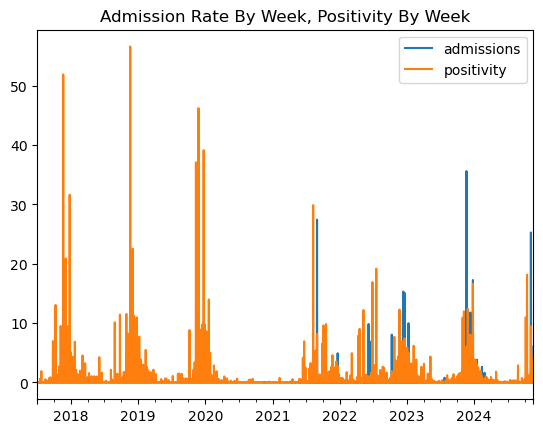

In [19]:
ax=dataframe.plot() # easy peasy...
ax.set_title('Admission Rate By Week, Positivity By Week');
# Using the pandas plot() method, these two lines of code produce a line plot of the data contained in the dataframe.
# "Admission Rate By Week, Positivity By Week" is the title that is added to the plot using the “ax.set_title()” method.
# Using the dates as the x-axis and the related metric values as the y-axis, the plot will show the trends for both "admissions" and "positivity" over time.

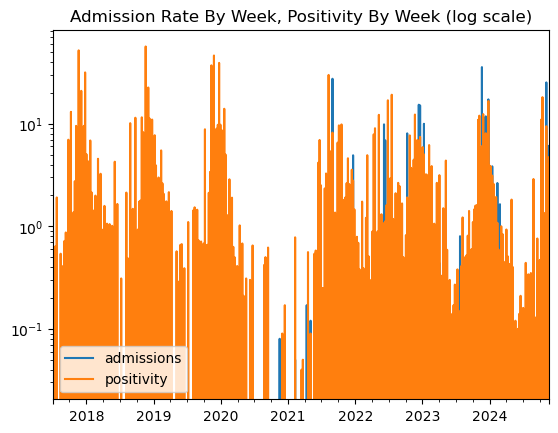

In [20]:
ax=dataframe.plot(logy=True) # ...lemon squeezy
ax.set_title('Admission Rate By Week, Positivity By Week (log scale)');
# With the y-axis shown on a logarithmic scale, these two lines of code create a line plot of the dataframe.
# To visualise data that spans a wide range, the plot is created and the logarithmic scale is applied to the y-axis in the first line, axe = dataframe.plot(logy=True).
# In order to help readers understand how the data is being displayed, the second line, ax.set_title('Admission Rate By Week, Positivity By Week (log scale)'), sets the plot's title to show that the y-axis is using a logarithmic scale.

In [21]:
from IPython.display import clear_output
import ipywidgets as wdg
import pandas as pd
import matplotlib.pyplot as plt
# Important Python libraries for creating interactive data visualisations are imported by this code.
# In order to enable dynamic updates to visualisations, it imports `clear_output` from IPython to clear the output in Jupyter notebooks.
# To create interactive widgets that let users interact with the data, such as buttons or sliders, the `ipywidgets` library is imported. Data analysis tasks require the use of `pandas` to manage and manipulate structured data in the form of DataFrames.
# The data may then be seen in charts and graphs thanks to the import of “matplotlib.pyplot”, which creates a variety of plots and visualisations. When combined, these libraries offer the resources needed to efficiently and intuitively develop and interact with data visualisations.

In [22]:
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100
# In a Jupyter notebook, this code sets up the plot display.
# While `plt.rcParams['figure.dpi'] = 100` raises the resolution of the figures to make them clearer and more detailed—especially useful for presentations or high-quality visualizations—the `%matplotlib inline` command guarantees that plots are displayed immediately inside the notebook.

In [23]:
import ipywidgets as wdg
from IPython.display import display
import time

def access_api(button):
    time.sleep(2)
    button.icon = "check"
    button.disabled = True

apibutton = wdg.Button(
    description='Refresh data',
    disabled=False,
    button_style='',
    tooltip='Click to download current Public Health England data',
    icon='download'
)

apibutton.on_click(access_api)
display(apibutton)
# This code uses "ipywidgets" to generate an interactive button in a Jupyter notebook. 
# When the button is pressed, it waits two seconds ("time.sleep(2)") to mimic downloading data, then turns the button's icon into a checkmark ("button.icon = "check") and turns it off ("button.disabled = True").
# "Refresh data" is the button's label, and a tooltip describing its purpose is included.
# The button is shown using "display(apibutton)", and the "on_click" method connects the button press to the "access_api" function. This offers an interactive and visible method of simulating a notebook data refresh.

Button(description='Refresh data', icon='download', style=ButtonStyle(), tooltip='Click to download current Pu…

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as wdg


dates = pd.date_range(start='2017-07-03', end='2024-11-11', freq='W')
data = { 
    'admissions': np.random.randint(1, 300, size=len(dates)),
    'positivity': np.random.randint(1, 300, size=len(dates))
}

dataframe = pd.DataFrame(data, index=dates)


series = wdg.SelectMultiple(
    options=['admissions', 'positivity'],
    value=['admissions', 'positivity'],
    rows=3,
    description='Stats:',
    disabled=False
)

scale = wdg.RadioButtons(
    options=['linear', 'log'],
    description='Scale:',
    disabled=False
)

controls = wdg.HBox([series, scale])


def timeseries_graph(gcols, gscale):
    if gscale == 'linear':
        logscale = False
    else:
        logscale = True
    
    
    selected_data = dataframe[list(gcols)]
    
    
    if logscale:
        epsilon = 1e-5
        selected_data = selected_data + epsilon  
    
    
    ax = selected_data.plot(logy=logscale)
    ax.set_ylabel('Rate')
    ax.set_title('RSV Data')
    plt.show()


graph = wdg.interactive_output(timeseries_graph, {'gcols': series, 'gscale': scale})


display(controls, graph)
# This code uses "ipywidgets" and "matplotlib" to construct an interactive dashboard in a Jupyter notebook that visualises weekly RSV (Respiratory Syncytial Virus) data.
# Over a range of dates, it produces random data for two metrics: "admissions" and "positivity."
# In addition to choosing between linear and logarithmic scales for the graph, the user may decide which metrics to plot.
# Based on user inputs, the "interactive_output" function dynamically updates the plot, presenting the data with the selected parameters.
# This makes it simple to examine the data in various visual representations.

Output()